# Disaster Tweets — Basic Network Embeddings & BERT

This notebook aims to explore the functionality of the [Texthero](https://texthero.org/) package, which makes use of multiple NLP and machine learning toolkits such as Gensim, NLTK, spaCy and scikit-learn. Texthero provides functions to work with text data, and is designed to be used on top of Pandas. We will mainly use Texthero to preprocess text data.

After text cleaning, we attempt to learn our own word embeddings using neural networks for text classification. Following that, we look at transfer learning through the use of pre-trained models. There are many pre-trained word embeddings like [GloVe](https://nlp.stanford.edu/projects/glove/), but we look at a more robust contextual embedding, [BERT](https://github.com/google-research/bert), which generates embeddings that takes into account the context or surrounding words, and is based on the Transformer architecture.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import texthero as hero
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow_addons.metrics import F1Score

plt.style.use("fivethirtyeight")

/opt/conda/lib/python3.7/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


---

# 1. Exploring Data

In [3]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv").drop(columns=["location"])
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv").drop(columns=["location"])

print("="*40)
print(f"Dimensions of training data: {train.shape}")
print(f"Dimensions of testing data: {test.shape}")
print("="*40)
train.tail()

Dimensions of training data: (7613, 4)
Dimensions of testing data: (3263, 3)


,id,keyword,text,target
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,The Latest: More Homes Razed by Northern Calif...,1


For the problem to identify disaster tweets, we will not be using the location column. While the column may convey information on the physical location of the disaster, we can check that there are way too many unique values (almost half the training data) for the column to be useful.

In contrast, the keyword column only has 222 unique values and may provide additional information that is not present in the tweet. For simplicity, we fill the missing values with an empty string to indicate the lack of a keyword. From the percentage plot below, we observe that there are many keywords which mostly belong to disaster or non-disaster tweets. 

However, we note that there are also a number of keywords with approximately equal proportions in both disaster and non-disaster tweets. These keywords may not be as helpful for our models. To identify the useful keywords, we need to set a threshold. Before that, we need to clean the data because some keywords like ``suicide%20bombing`` and ``suicide%20bomb`` generally refer to the same context. We look at text cleaning in the next section.

In [4]:
def plot_top_keywords(df_train, top=15, mid=0, **kwargs):
    assert top!=0 and mid>=0. and mid<=1.
    df = df_train.copy()
    df_count = df.groupby("keyword").target.value_counts().unstack("target").fillna(0).astype(int)
    df_prop = df.groupby("keyword").target.value_counts(normalize=True).unstack("target").fillna(0).sort_values(0)
    if not mid:
        df_plot = df_prop.iloc[:top, :].iloc[::-1] if top>0 else  df_prop.iloc[top:, :]
    else:
        idx = int(mid*len(df_prop.index))
        df_plot = df_prop.iloc[idx:idx+top, :]
    
    df_plot.plot(
        kind="barh",
        stacked=True,
        **kwargs,
    )
    for idx, row in df_plot.iterrows():
        if row[0] > 0.2:
            plt.text(
                x=row[0]/2,
                y=df_plot.index.tolist().index(idx),
                s=f"{row[0]*100:.1f}% ({df_count.loc[idx, 0]})",
                va="center",
                ha="center",
                color="white",
            )
        if row[1] > 0.2:
            plt.text(
                x=row[0]+row[1]/2,
                y=df_plot.index.tolist().index(idx),
                s=f"{row[1]*100:.1f}% ({df_count.loc[idx, 1]})",
                va="center",
                ha="center",
                color="white",
            )
    
    num_keyword = len(df_plot.index)
    if not mid:
        top_or_bot = "Highest" if top>0 else "Lowest"
        plt.title(f"Top {num_keyword} Keywords with {top_or_bot} % of Disaster Tweets")
    else:
        plt.title(f"Random {num_keyword} Keywords")
        
    plt.xlabel("Proportion")
    plt.ylabel("")
    plt.legend(["Not Disaster", "Disaster"], loc="upper left")

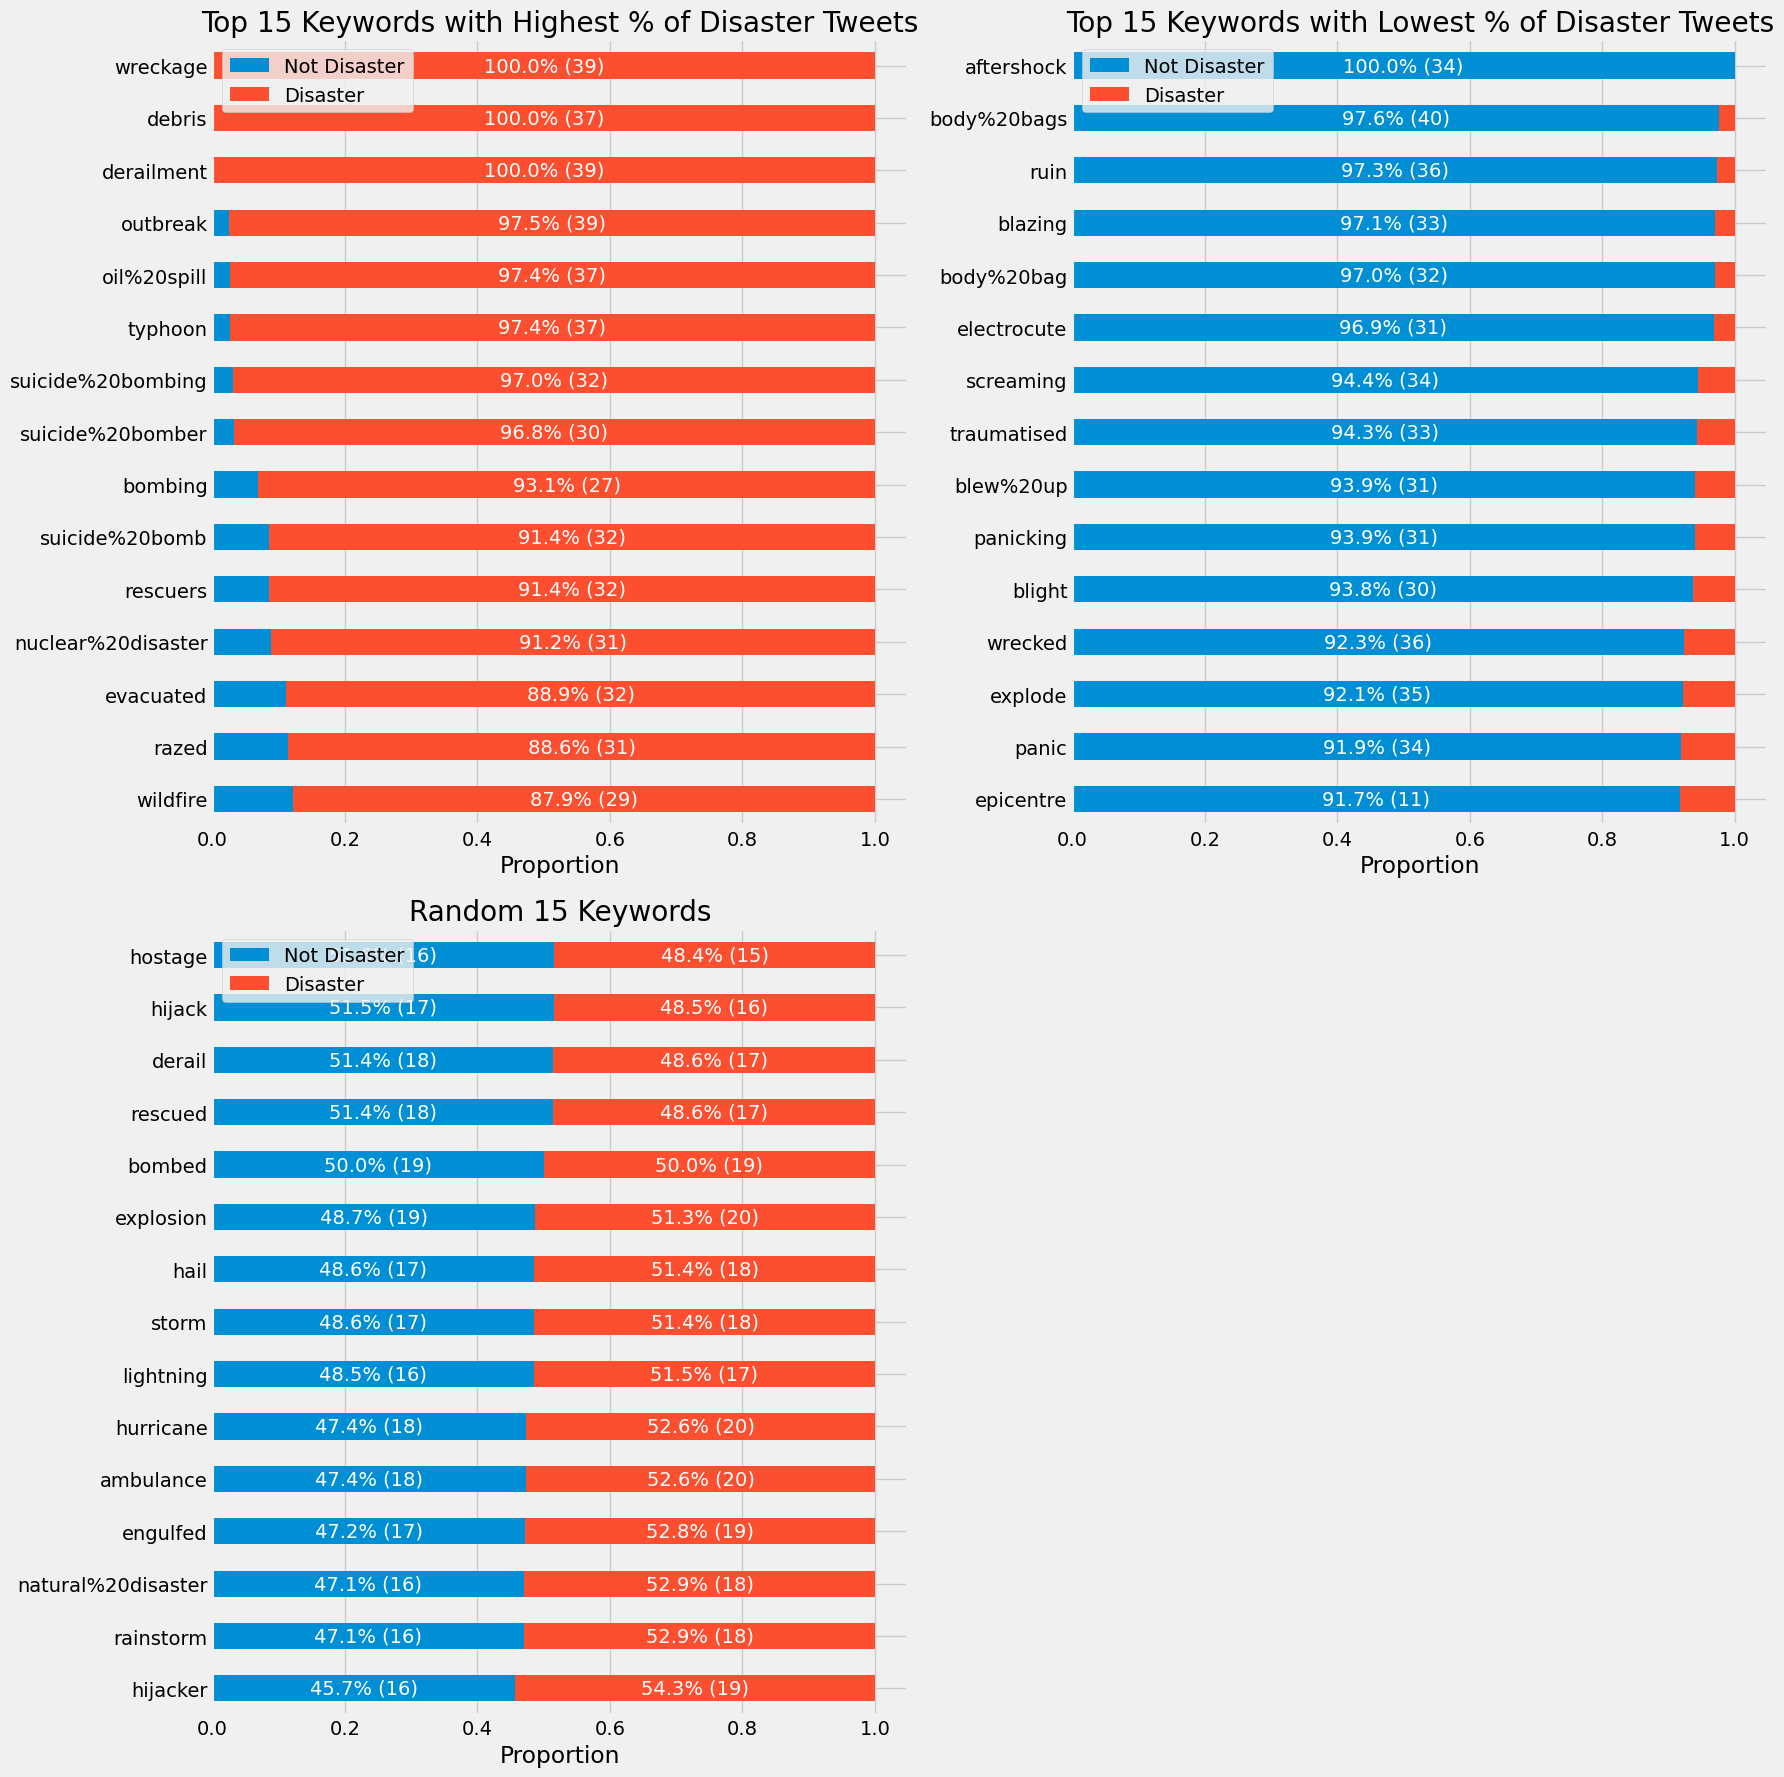

In [5]:
train.keyword = train.keyword.fillna("")
test.keyword = test.keyword.fillna("")

fig = plt.figure(figsize=(18, 18))

plot_top_keywords(train, top=15, ax=fig.add_subplot(221))
plot_top_keywords(train, top=-15, ax=fig.add_subplot(222))
plot_top_keywords(train, mid=0.35, ax=fig.add_subplot(223))

plt.tight_layout()

---

# 2. Understanding Text Preprocessing

We now create functions for text cleaning. Our data contains the following non-exhaustive list of information:
* Uppercased and lowercased characters,
* Diacritics and accents,
* Punctuation marks,
* Blocks of digits,
* Stopwords,
* Words of different forms (e.g. bags vs. bag),
* Additional whitespaces,
* URLs,
* HTML tags,
* Tweet @mentions.

There could be other information like emojis and spelling errors, but we will make do with the above list, which can still be managed using Texthero methods. The list of methods can be found [here](https://texthero.org/docs/api-preprocessing) and [here](https://github.com/jbesomi/texthero/blob/master/texthero/preprocessing.py), or by simply calling the ``dir()`` function. 

In [6]:
print(dir(hero))

['Callable', 'CountVectorizer', 'Counter', 'DBSCAN', 'KMeans', 'List', 'MeanShift', 'NMF', 'Optional', 'PCA', 'PhrasesTransformer', 'PorterStemmer', 'Set', 'SnowballStemmer', 'TSNE', 'TfidfVectorizer', 'Word2Vec', 'WordCloud', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'clean', 'cosine_similarity', 'dbscan', 'drop_no_content', 'fillna', 'get_default_pipeline', 'has_content', 'kmeans', 'logging', 'lowercase', 'lsg', 'meanshift', 'most_similar', 'named_entities', 'nlp', 'nmf', 'noun_chunks', 'np', 'pca', 'pd', 'plt', 'preprocessing', 'px', 're', 'remove_angle_brackets', 'remove_brackets', 'remove_curly_brackets', 'remove_diacritics', 'remove_digits', 'remove_html_tags', 'remove_punctuation', 'remove_round_brackets', 'remove_square_brackets', 'remove_stopwords', 'remove_urls', 'remove_whitespace', 'replace_digits', 'replace_punctuation', 'replace_stopwords', 'replace_urls', 'representation', 'scatterplot', 'spacy',

Depending on the context of the problem, it may be useful to standardize/remove the above information, or leave it as is. To determine the usefulness of the information, we temporarily replace them with tags (e.g. ``[PTT]`` for punctuation marks). After text cleaning, we can extract features from these tags. The functions defined for text cleaning are listed below.

In [7]:
def text_pp(s, fn):
    print("BEFORE:")
    print(s.values[0])
    print("\nAFTER:")
    print(fn(s).values[0])

### Coverting to lowercase.

In [8]:
text_pp(train[["text"]].iloc[210], fn=hero.lowercase)

BEFORE:
THEY SHALL BE ANNIHILATED AND ALL OF THEIR PETEBESTS DESSICATED AND LAID BARE. THEN YOU SHALL KNEEL BEFORE ME.

AFTER:
they shall be annihilated and all of their petebests dessicated and laid bare. then you shall kneel before me.


### Removing diacritics and accents.

In [9]:
text_pp(train[["text"]].iloc[38], fn=hero.remove_diacritics)

BEFORE:
Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J

AFTER:
Barbados #Bridgetown JAMAICA UO Two cars set ablaze: SANTA CRUZ UO Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J


### Replacing URLs.

In [10]:
def replace_urls(s):
    return hero.replace_urls(s, symbol=" [URL] ")

In [11]:
text_pp(train[["text"]].iloc[-1], fn=replace_urls)

BEFORE:
The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d

AFTER:
The Latest: More Homes Razed by Northern California Wildfire - ABC News  [URL] 


/opt/conda/lib/python3.7/site-packages/texthero/preprocessing.py:664: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(pattern, symbol)


### Replacing HTML tags.

In [12]:
def replace_html_tags(s):
    pattern = r"""(?x)                              
      <[^>]+>                                       
      | &([a-z0-9]+|\#[0-9]{1,6}|\#x[0-9a-f]{1,6});
      """
    
    return s.str.replace(pattern, "[HTM]", regex=True)

In [13]:
text_pp(train[["text"]].iloc[64], fn=replace_html_tags)

BEFORE:
#NowPlaying: Rene Ablaze &amp; Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM

AFTER:
#NowPlaying: Rene Ablaze [HTM] Ian Buff - Magnitude http://t.co/Av2JSjfFtc  #EDM


### Replacing @mentions.

In [14]:
def replace_mentions(s):
    return s.str.replace(r"@\w+", " [MTN] ", regex=True)

In [15]:
text_pp(train[["text"]].iloc[54], fn=replace_mentions)

BEFORE:
Noches El-Bestia '@Alexis_Sanchez: happy to see my teammates and training hard ?? goodnight gunners.?????? http://t.co/uc4j4jHvGR'

AFTER:
Noches El-Bestia ' [MTN] : happy to see my teammates and training hard ?? goodnight gunners.?????? http://t.co/uc4j4jHvGR'


### Replacing punctuations.

In [16]:
def replace_punctuation(s):
    s = s.str.replace(r"[^a-zA-Z0-9\s\[\]]", " [PTT] ", regex=True)
    s = s.str.replace(r"\[(?![A-Z]{3}\])", " [PTT] ", regex=True)
    s = s.str.replace(r"(?<!\[[A-Z]{3})\]", " [PTT] ", regex=True)
    
    return s

In [17]:
text_pp(train[["text"]].iloc[2641], fn=replace_punctuation)

BEFORE:
Marquei como visto Dragon Ball Super - 1x1 - The God of Destruction\'s Dream http://t.co/vJLnsKbG86 #bancodeseries

AFTER:
Marquei como visto Dragon Ball Super  [PTT]  1x1  [PTT]  The God of Destruction [PTT]  [PTT] s Dream http [PTT]  [PTT]  [PTT] t [PTT] co [PTT] vJLnsKbG86  [PTT] bancodeseries


### Replacing digits.

In [18]:
def replace_digits(s):
    return hero.replace_digits(s, symbols=" [DIG] ")

In [19]:
text_pp(train[["text"]].iloc[45], fn=replace_digits)

BEFORE:
I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6

AFTER:
I gained  [DIG]  followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6


/opt/conda/lib/python3.7/site-packages/texthero/preprocessing.py:72: FutureWarning: The default value of regex will change from True to False in a future version.
  return input.str.replace(pattern, symbols)


### Replacing stopwords.

In [20]:
def replace_stopwords(s):
    return hero.replace_stopwords(s, symbol=" [STP] ")

In [21]:
text_pp(train[["text"]].iloc[18], fn=replace_stopwords)

BEFORE:
My car is so fast

AFTER:
My car  [STP]   [STP]  fast


### Stemming words.

In [22]:
text_pp(train[["text"]].iloc[14], fn=hero.stem)

BEFORE:
Damage to school bus on 80 in multi car crash #BREAKING 

AFTER:
damag to school bus on 80 in multi car crash #break


### Removing whitespaces.

In [23]:
text_pp(train[["text"]].iloc[7552], fn=hero.remove_whitespace)

BEFORE:
Israel wrecked my home. Now it wants my land. 
https://t.co/g0r3ZR1nQj

AFTER:
Israel wrecked my home. Now it wants my land. https://t.co/g0r3ZR1nQj


In [24]:
def remove_spaces(s):
    return s.str.replace(r"%20", " ", regex=True)

In [25]:
text_pp(train[["keyword"]].iloc[136], fn=remove_spaces)

BEFORE:
airplane%20accident

AFTER:
airplane accident


---

# 3. Defining Custom Pipelines for Text Preprocessing

### Cleaning keywords.

We first clean the keyword column before combining it with the actual tweet. We define a custom pipeline containing the relevant methods used for our problem; the functions are applied according to the order listed in the pipeline.

After text cleaning, the number of unique keywords reduced from 222 to 167, indicating that many of the original keywords listed share similar information but are labeled in a different form. As described earlier, we set the threshold such that keywords with at least 70% disaster or non-disaster tweets will be combined with the original tweet.

In [26]:
clean_keywords = [
    remove_spaces,
    hero.remove_stopwords,
    hero.stem,
    hero.remove_whitespace,
]

train["clean_keyword"] = hero.clean(train.keyword, pipeline=clean_keywords)
test["clean_keyword"] = hero.clean(test.keyword, pipeline=clean_keywords)

print("="*40)
print(f"{train.keyword.nunique()} keywords reduced to {train.clean_keyword.nunique()} keywords:")
print("="*40)
print(train.clean_keyword.unique().tolist())

222 keywords reduced to 167 keywords:
['', 'ablaz', 'accid', 'aftershock', 'airplan accid', 'ambul', 'annihil', 'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist', 'attack', 'avalanch', 'battl', 'bioterror', 'blaze', 'bleed', 'blew', 'blight', 'blizzard', 'blood', 'bloodi', 'blown', 'bodi bag', 'bomb', 'bridg collaps', 'build burn', 'build fire', 'burn', 'burn build', 'bush fire', 'casualti', 'catastroph', 'chemic emerg', 'cliff fall', 'collaps', 'collid', 'collis', 'crash', 'crush', 'curfew', 'cyclon', 'damag', 'danger', 'dead', 'death', 'debri', 'delug', 'demolish', 'demolit', 'derail', 'desol', 'destroy', 'destruct', 'deton', 'devast', 'disast', 'displac', 'drought', 'drown', 'dust storm', 'earthquak', 'electrocut', 'emerg', 'emerg plan', 'emerg servic', 'engulf', 'epicentr', 'evacu', 'explod', 'explos', 'eyewit', 'famin', 'fatal', 'fear', 'fire', 'fire truck', 'first respond', 'flame', 'flatten', 'flood', 'forest fire', 'hail', 'hailstorm', 'harm', 'hazard', 'heat wave', 'hellf

In [27]:
THRESH = 0.7

keyword_prop = train.groupby("clean_keyword").target.value_counts(normalize=True).unstack("target")
keyword_prop = keyword_prop.fillna(0).sort_values(0)
keywords_keep = keyword_prop[(keyword_prop[0]<=(1-THRESH)) | (keyword_prop[0]>=THRESH)].index

train.clean_keyword = train.clean_keyword.apply(lambda x: x if x in keywords_keep else "")
test.clean_keyword = test.clean_keyword.apply(lambda x: x if x in keywords_keep else "")

### Cleaning text.

 With the large amount of information to be cleaned in the actual tweet, the order of the functions listed in the pipeline is important. For example, if we replace punctuations before replacing URLs, the forward slashes ``/`` contained in URLs will be removed so the original URLs may not be recognized properly. Subsequently, we combine the keywords with the tweets by adding the keywords to the end.

In [28]:
clean_text = [
    hero.lowercase,
    hero.remove_diacritics,
    hero.remove_whitespace,
    replace_urls,
    replace_html_tags,
    replace_mentions,
    replace_punctuation,
    replace_digits,
    replace_stopwords,
    hero.stem,
    hero.remove_whitespace,
]

train["clean_text"] = train.text + " " + train.clean_keyword
test["clean_text"] = test.text + " " + test.clean_keyword

train.clean_text = hero.clean(train.clean_text, pipeline=clean_text)
test.clean_text = hero.clean(test.clean_text, pipeline=clean_text)

train.head()

,id,keyword,text,target,clean_keyword,clean_text
0,1,,Our Deeds are the Reason of this #earthquake M...,1,,[stp] deed [stp] [stp] reason [stp] [stp] [ptt...
1,4,,Forest fire near La Ronge Sask. Canada,1,,forest fire near la rong sask [ptt] canada
2,5,,All residents asked to 'shelter in place' are ...,1,,[stp] resid ask [stp] [ptt] shelter [stp] plac...
3,6,,"13,000 people receive #wildfires evacuation or...",1,,[dig] [ptt] [dig] peopl receiv [ptt] wildfir e...
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,,[stp] got sent [stp] photo [stp] rubi [ptt] al...


---

# 4. Feature Engineering

### Extracting features from text.

After text cleaning, we can extract features from the text by counting the tags used to temporarily replace the corresponding information. In addition, other features like counting the number of characters or number of words (excluding the information removed) can be created.

In [29]:
def extract_features(df):
    if any("num" in j for j in df.columns):
        return df
    df = df.copy()
    
    features = ["url", "htm", "mtn", "ptt", "dig", "stp"]
    for feat in features:
        df[f"num_{feat}"] = df.clean_text.apply(lambda x: x.count(f"[{feat}]"))
        df.clean_text = df.clean_text.str.replace(rf"\[{feat}\]", "", regex=True)
        
    df.clean_text = hero.remove_whitespace(df.clean_text)
    df["num_char"] = (df.clean_text).apply(len)
    df["num_word"] = hero.tokenize(df.clean_text).apply(len)
    
    return df

In [30]:
train = extract_features(train)
test = extract_features(test)

train.head()

/opt/conda/lib/python3.7/site-packages/texthero/preprocessing.py:598: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(pattern, r"\2 \3 \4 \5").str.split()


,id,keyword,text,target,clean_keyword,clean_text,num_url,num_htm,num_mtn,num_ptt,num_dig,num_stp,num_char,num_word
0,1,,Our Deeds are the Reason of this #earthquake M...,1,,deed reason earthquak may allah forgiv us,0,0,0,1,0,6,41,7
1,4,,Forest fire near La Ronge Sask. Canada,1,,forest fire near la rong sask canada,0,0,0,1,0,0,36,7
2,5,,All residents asked to 'shelter in place' are ...,1,,resid ask shelter place notifi offic evacu she...,0,0,0,3,0,11,69,11
3,6,,"13,000 people receive #wildfires evacuation or...",1,,peopl receiv wildfir evacu order california,0,0,0,2,2,1,43,6
4,7,,Just got sent this photo from Ruby #Alaska as ...,1,,got sent photo rubi alaska smoke wildfir pour ...,0,0,0,2,0,7,52,9


### Evaluating usefulness of features extracted.

To evaluate the usefulness of the features extracted, we look at their density plots. For a better quantification, we can estimate the mutual information, measuring the dependency between the features and the target variable. We observe that the only difference in distributions is that disaster tweets tend to contain URLs (where values are most concentrated on 1 and above), and have slightly more characters and words (where the distribution is shifted a little to the right). Otherwise, the distributions for both disaster and non-disaster tweets look similar for most features. For simplicity, we do not consider any of these features in our models.

In [31]:
def feature_plot(df, features):
    df = df.copy()
    
    nrow = (len(features)//3) + 1
    fig = plt.figure(figsize=(18, 4.5*nrow))
    for i, feat in enumerate(features):
        ax = fig.add_subplot(nrow, 3, i+1)
        
        sns.kdeplot(
            x=df[feat][df.target==0],
            fill=True,
            lw=3,
            ax=ax,
            label="Not Disaster",
        )
        # plot separately to rescale for better comparison of the distribution shape
        sns.kdeplot(
            x=df[feat][df.target==1],
            fill=True,
            lw=3,
            ax=ax,
            label="Disaster",
        )
        
        mi = mutual_info_classif(
            X=df[feat].values.reshape(-1, 1),
            y=df.target,
            random_state=1234,
        )[0]
        ax.set_title(f"Mutual Information: {mi:.4f}")
        ax.legend(loc="upper right")
        
    plt.tight_layout()

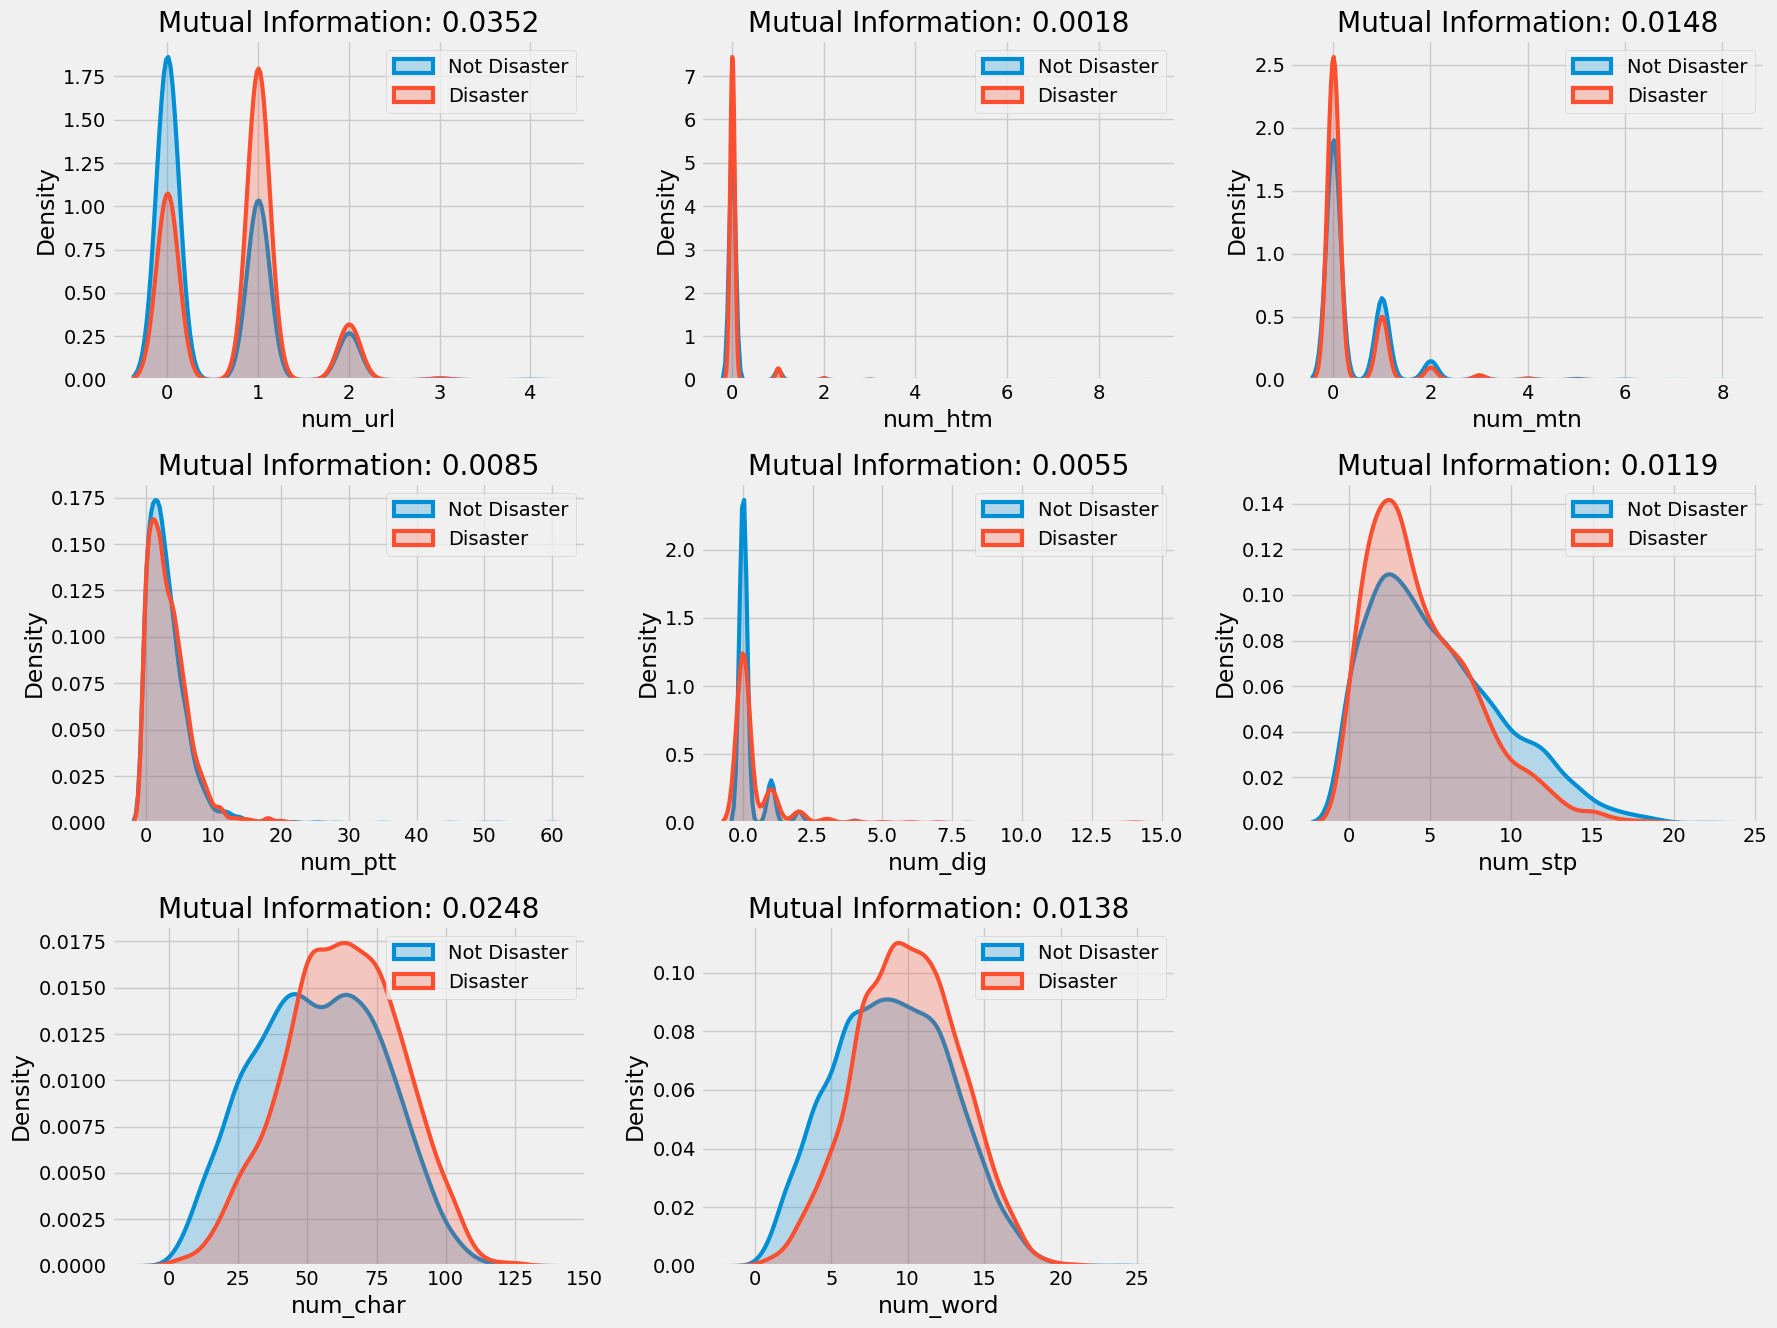

In [32]:
feature_plot(train, features=[col for col in train.columns if "num" in col])

### Detecting *n*-grams.

*N*-grams are defined to be a contiguous sequence of *n* words. Because we are dealing with tweets which are generally informal and short in length, we only consider up to bigrams. We use ``hero.PhrasesTransformer()`` which wraps ``gensim.models.phrases.Phrases`` to detect bigrams based on collocation counts. The two words are concatenated together if they are detected as bigrams.

In [33]:
train_tokenized = hero.tokenize(train.clean_text)
test_tokenized = hero.tokenize(test.clean_text)

bigram_detector = hero.PhrasesTransformer()
train_bigram = bigram_detector.fit_transform(train_tokenized)
test_bigram = bigram_detector.transform(test_tokenized)

train["bigram_text"] = pd.Series(train_bigram).apply(lambda x: " ".join(x))
test["bigram_text"] = pd.Series(test_bigram).apply(lambda x: " ".join(x))

/opt/conda/lib/python3.7/site-packages/texthero/preprocessing.py:598: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(pattern, r"\2 \3 \4 \5").str.split()


Using the example shown below, the words ``heavy`` and ``flash`` belonging to ``heavy rain`` and ``flash flood`` could have totally different meanings by themselves depending on the context.

In [34]:
print("BEFORE:")
print(train_tokenized[6])
print("\nAFTER:")
print(train_bigram[6])

BEFORE:
['flood', 'disast', 'heavi', 'rain', 'caus', 'flash', 'flood', 'street', 'manitou', 'colorado', 'spring', 'area']

AFTER:
['flood', 'disast', 'heavi_rain', 'caus', 'flash_flood', 'street', 'manitou', 'colorado', 'spring', 'area']


---

# 5. Classifying Text with Basic Network Embeddings

In [35]:
train_data, valid_data, train_labels, valid_labels = train_test_split(
    train.drop(columns=["target"]), train.target,
    test_size=0.1,
    stratify=train.target,
    random_state=1234,
)

### Tokenizing text.

To feed text into neural networks we need to tokenize the text and then index or vectorize them. Here we are trying to learn our own word embeddings using an embedding layer, so we turn each text into a sequence of indices using ``tensorflow.keras.preprocessing.text.Tokenizer``, each unique word having its own index. We can specify the size of the vocabulary ``VOCAB_SIZE``, denoting the maximum number of words to keep based on word frequency. To ensure our text inputs are of the same size, we call ``tensorflow.keras.preprocessing.sequence.pad_sequences`` to pad or truncate each sequence to the same length. This length can be controlled by ``MAX_LENGTH``. Also, there could be words present in the validation or testing data that are not found in the training data. To allow for better learning, these missing words can be represented using a out-of-vocabulary (OOV) token ``OOV_TOK``.

In [36]:
VOCAB_SIZE = 10000
MAX_LENGTH = 20
OOV_TOK = "[OOV]"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK, filters="")
tokenizer.fit_on_texts(train_data.bigram_text)

train_seq = tokenizer.texts_to_sequences(train_data.bigram_text)
train_padded = pad_sequences(train_seq, maxlen=MAX_LENGTH)

valid_seq = tokenizer.texts_to_sequences(valid_data.bigram_text)
valid_padded = pad_sequences(valid_seq, maxlen=MAX_LENGTH)

test_seq = tokenizer.texts_to_sequences(test.bigram_text)
test_padded = pad_sequences(test_seq, maxlen=MAX_LENGTH)

Below is an example of the results from tokenization, where words like ``previouslyondoyintv``, ``makinwaua`` and ``marriag`` are not found in the training data and are thus replaced by the OOV token. By default, padding and truncating happens at the start of the sequence.

In [37]:
print("ORIGINAL CLEAN TEXT:")
print(test.bigram_text.iloc[17])
print("\nTOKENIZED SEQUENCE:")
print(test_seq[17])
print("\nPADDED SEQUENCE:")
print(test_padded[17].tolist())
print("\nTRANSFORMED TEXT:")
print(tokenizer.sequences_to_texts([test_seq[17]])[0])

ORIGINAL CLEAN TEXT:
previouslyondoyintv toke makinwaua marriag crisi set nigerian twitter ablaz

TOKENIZED SEQUENCE:
[1, 1, 1, 5482, 1760, 186, 2819, 356, 595]

PADDED SEQUENCE:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 5482, 1760, 186, 2819, 356, 595]

TRANSFORMED TEXT:
[OOV] [OOV] [OOV] marriag crisi set nigerian twitter ablaz


### Setting model configuration parameters.

For model training, we set up an exponential decay learning rate schedule and early stopping to prevent overfitting.

In [38]:
INIT_LR = 5e-4
DECAY_RATE = 0.5

lr_schedule = LearningRateScheduler(lambda epoch: INIT_LR * (DECAY_RATE**epoch))
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4, # minor improvements not considered
    patience=3,
    restore_best_weights=True,
)
metric = F1Score(num_classes=1, threshold=0.5)

MODEL_CONFIG = {
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "metrics": [metric],
}
TRAIN_CONFIG = {
    "x": train_padded,
    "y": train_labels,
    "callbacks": [lr_schedule, early_stopping],
    "epochs": 50, # training stopped using early stopping
    "batch_size": 16,
    "validation_data": (valid_padded, valid_labels),
    "verbose": 0,
}

def model_predict(model, X):
    return (model.predict(X, verbose=0)>0.5).reshape(-1,).astype(int)

In [39]:
def model_eval(history, true, pred):
    num_epoch = len(history["loss"])
    xtick_freq = (num_epoch//10) + 1
    xtick_labels = np.arange(num_epoch, step=xtick_freq, dtype=int)
    plt.figure(figsize=(18, 4.5))

    plt.subplot(131)
    plt.plot(history["loss"], "-o", label = "Training")
    plt.plot(history["val_loss"], "-o", label = "Validation")
    plt.xlabel("Epoch")
    plt.xticks(xtick_labels, xtick_labels+1)
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend(loc="upper right")

    plt.subplot(132)
    plt.plot(history["f1_score"], "-o", label = "Training")
    plt.plot(history["val_f1_score"], "-o", label = "Validation")
    plt.xlabel("Epoch")
    plt.xticks(xtick_labels, xtick_labels+1)
    plt.ylabel("F1 Score")
    plt.title("F1 Score Curves")
    plt.legend(loc="lower right")

    plt.subplot(133)
    idx = np.argmin(history["val_loss"])
    score = history["val_f1_score"][idx][0]
    cf_mat = confusion_matrix(true, pred)
    cf_mat_norm = confusion_matrix(true, pred, normalize="all")
    labels = [f"{ct}\n({pt*100:.1f}%)" for ct, pt in zip(cf_mat.ravel(), cf_mat_norm.ravel())]
    labels = np.array(labels).reshape(2, 2)

    sns.heatmap(
        cf_mat,
        annot=labels,
        cmap="Blues",
        fmt="",
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation F1 Score: {score:.4f}")
    
    plt.tight_layout()    

### Building network architecture.

Neural network embeddings provide a method to represent discrete variables as continuous vectors. Here we are trying to learn continuous vector representations of each word. This helps reduce dimensionality, compared to other methods like one-hot embedding which maps each word to a different vector. Moreover, the vectors of words that share similar meaning in the given context will be closer in the embedding space.

To build the model, we first define an embedding layer that turns the text input into vectors of dimensions specified by ``output_dim``. As this is a binary classification problem, the output layer has simply 1 unit, with a sigmoid activation function mapping the output to a probability value. We look at using different layers after the embedding layer:
* **Bidirectional GRU** — connects 2 GRU layers of opposite directions to the next layer. This has the advantage of getting information from past and future states simultaneously, effectively understanding the words in context.
* **Convolution + global average pooling**. The convolution layer extracts features while the global average pooling layer condenses the information of each feature map.

For simplicity, we do not add additional layers, and the models are manually tuned. The results are shown below.

In [40]:
def build_gru():
    gru_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE, output_dim=16, input_length=MAX_LENGTH),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16, dropout=0.4)),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])
    gru_model.compile(**MODEL_CONFIG)
    
    return gru_model

def build_cnn():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE, output_dim=16, input_length=MAX_LENGTH),
        tf.keras.layers.Conv1D(128, kernel_size=3, activation="relu", padding="same"),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ])
    cnn_model.compile(**MODEL_CONFIG)
    
    return cnn_model

### Training GRU model.

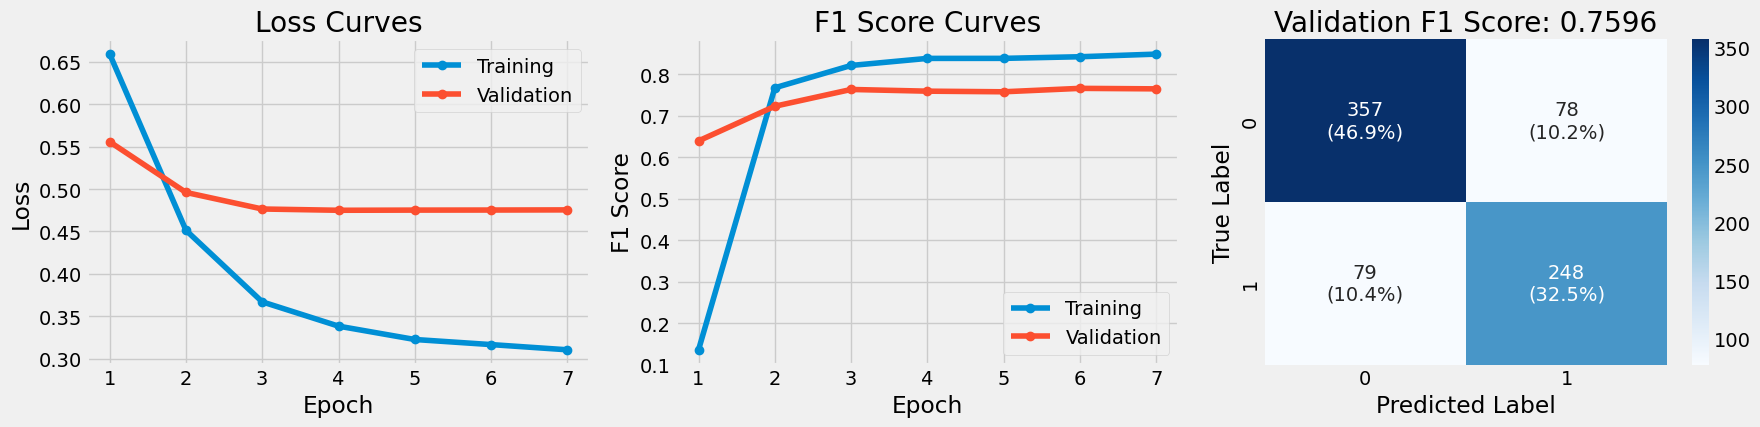

In [41]:
gru_model = build_gru()
gru_history = gru_model.fit(**TRAIN_CONFIG).history

model_eval(gru_history, valid_labels, model_predict(gru_model, valid_padded))

### Training CNN model.

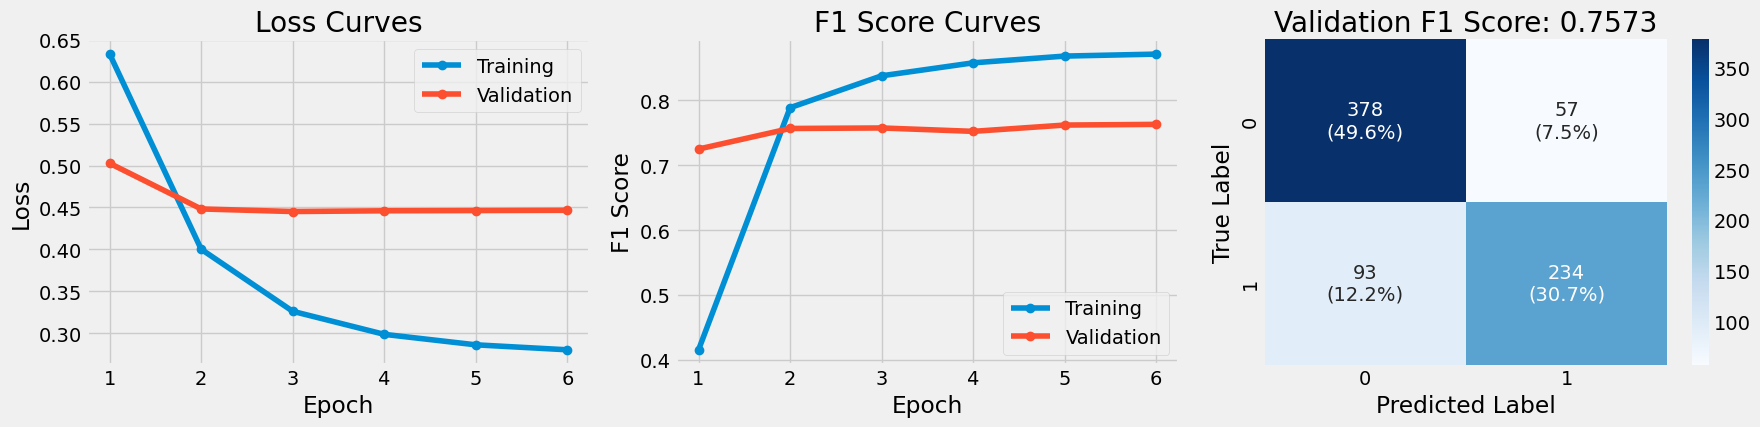

In [42]:
cnn_model = build_cnn()
cnn_history = cnn_model.fit(**TRAIN_CONFIG).history

model_eval(cnn_history, valid_labels, model_predict(cnn_model, valid_padded))

---

# 6. Classifying Text with BERT

There are many different BERT models that can be loaded from [TensorFlow Hub](https://tfhub.dev/) together with their corresponding preprocessing models. We can try different models by simply changing the below URLs to be loaded from.

In [43]:
HANDLE_PREPROCESS = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
HANDLE_ENCODER = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4"

### Understanding preprocessing model.

There are 3 outputs from preprocessing, which would then be used as inputs for the BERT model: ``input_word_ids`` is the unique index for each tokenized input, ``input_mask`` differentiates non-padding from padding tokens, and ``input_type_ids`` distinguishes multiple text segments per input. The input is truncated to 128 tokens by default.

In [44]:
bert_preprocessor = hub.KerasLayer(HANDLE_PREPROCESS)
example_input = bert_preprocessor([train.text.values[0]])

print("input_word_ids: ", example_input["input_word_ids"].numpy().tolist())
print("\ninput_mask    : ", example_input["input_mask"].numpy().tolist())
print("\ninput_type_ids: ", example_input["input_type_ids"].numpy().tolist())

input_word_ids:  [[101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

input_mask    :  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

input_type_ids:  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Understanding BERT model.

The BERT model also returns 3 outputs: ``pooled_output`` can be regarded as the embedding for each tweet, ``sequence_output`` can be considered the embedding for every token in each tweet, and ``encoder_outputs`` are the intermediate activations of the Transformer blocks. We are mainly concerned with ``pooled_output`` for our model.

In [45]:
bert_encoder = hub.KerasLayer(HANDLE_ENCODER)
example_output = bert_encoder(example_input)

print("pooled_output shape  : ", example_output["pooled_output"].shape)
print("sequence_output shape: ", example_output["sequence_output"].shape)
print(f"encoder_outputs shape: {len(example_output['encoder_outputs'])} Tensors with shape", example_output["encoder_outputs"][0].shape)

pooled_output shape  :  (1, 1024)
sequence_output shape:  (1, 128, 1024)
encoder_outputs shape: 24 Tensors with shape (1, 128, 1024)


### Building network architecture.

We build a [simple model](https://www.tensorflow.org/text/tutorials/classify_text_with_bert#define_your_model) using only the preprocessing model, the BERT model, and the output layer.

In [46]:
def build_bert():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
    bert_preprocessor = hub.KerasLayer(HANDLE_PREPROCESS)
    encoder_inputs = bert_preprocessor(text_input)
    bert_encoder = hub.KerasLayer(HANDLE_ENCODER, trainable=True)
    outputs = bert_encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dense(1, activation="sigmoid")(net)
    
    bert_model = tf.keras.Model(text_input, net)
    bert_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="binary_crossentropy",
        metrics=[metric],
    )
    
    return bert_model

### Training BERT model.

In [47]:
bert_model = build_bert()

early_stopping.patience = 1 # training stopped if current epoch shows no improvement
bert_history = bert_model.fit(
    x=train_data.text, # original text column used
    y=train_labels,
    epochs=50, # training stopped using early stopping
    callbacks=[early_stopping],
    batch_size=16,
    validation_data=(valid_data.text, valid_labels),
).history

Epoch 1/50
429/429 [==============================] - 510s 918ms/step - loss: 0.4577 - f1_score: 0.7390 - val_loss: 0.5065 - val_f1_score: 0.7804
Epoch 2/50
429/429 [==============================] - 388s 905ms/step - loss: 0.3631 - f1_score: 0.8166 - val_loss: 0.4172 - val_f1_score: 0.8085
Epoch 3/50
429/429 [==============================] - 388s 904ms/step - loss: 0.3105 - f1_score: 0.8524 - val_loss: 0.4170 - val_f1_score: 0.8123
Epoch 4/50
429/429 [==============================] - 382s 890ms/step - loss: 0.2683 - f1_score: 0.8781 - val_loss: 0.4407 - val_f1_score: 0.8031


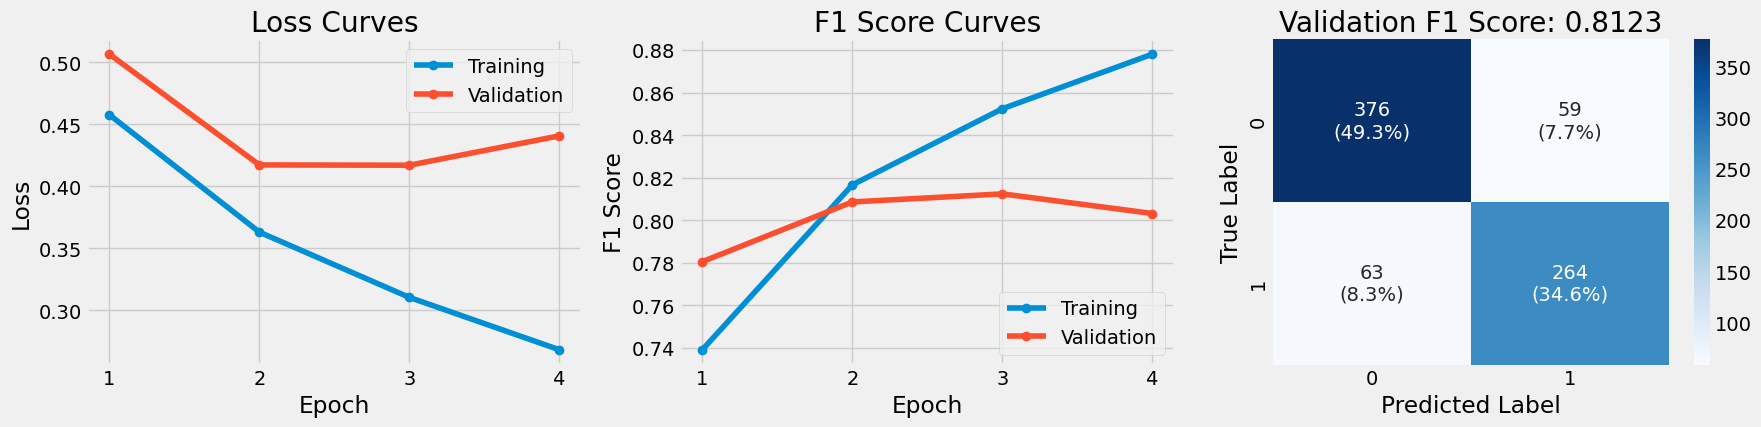

In [48]:
model_eval(bert_history, valid_labels, model_predict(bert_model, valid_data.text))

---

# 7. Submission

The pre-trained BERT model achieved a much better performance, showing the benefits of transfer learning. We use it as the final model for prediction.

In [49]:
submission = pd.DataFrame({
    "id": test.id,
    "target": model_predict(bert_model, test.text),
})

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [50]:
submission.to_csv("submission.csv", index=False)

---